1. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.

In [ ]:
select job_industry_category, count(*)
from customer c
group by job_industry_category
order by count(*) asc

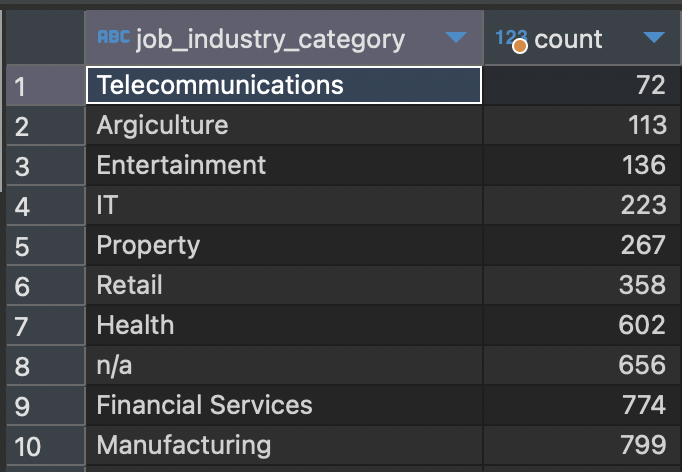

2. Найти сумму транзакций за каждый месяц по сферам деятельности, отсортировав по месяцам и по сфере деятельности.

In [ ]:
select extract(month from to_date(t2.transaction_date, 'dd.mm.yyyy')) as month,
       c.job_industry_category,
       count(transaction_id) as total_transaction_amount
from transaction2 t2
join customer c on t2.customer_id = c.customer_id
group by extract(month from to_date(t2.transaction_date, 'dd.mm.yyyy')), c.job_industry_category
order by month, c.job_industry_category;

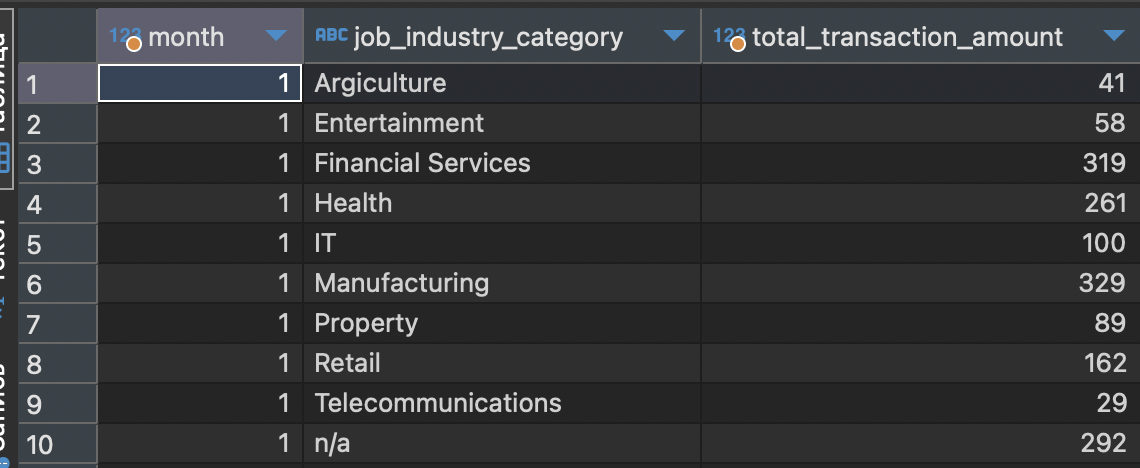

3. Вывести количество онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT.

In [ ]:
select t2.brand, count(transaction_id) transaction_of_IT_online
from transaction2 t2
join customer c on t2.customer_id = c.customer_id
where t2.online_order = true and c.job_industry_category = 'IT' and t2.order_status = 'Approved'
group by t2.brand

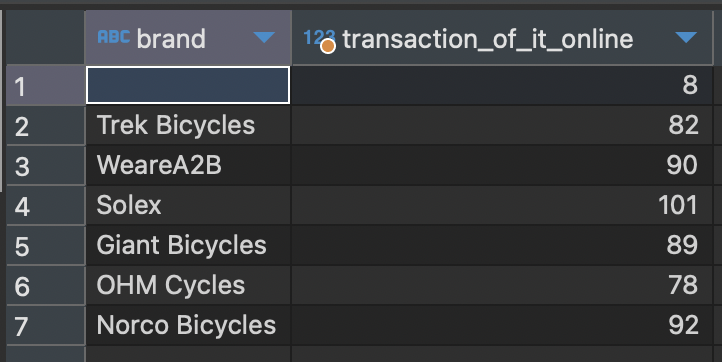

4. #Найти по всем клиентам сумму всех транзакций (list_price), максимум, минимум и количество транзакций, 
отсортировав результат по убыванию суммы транзакций и количества клиентов. Выполните двумя способами: 
используя только group by 
и используя только оконные функции. 
Сравните результат.

In [ ]:
select c.customer_id, c.last_name, sum(t2.list_price), max(t2.list_price), min(t2.list_price), count(t2.list_price)
from customer c
join transaction2 t2 on c.customer_id = t2.customer_id
group by c.customer_id, c.last_name
order by sum(t2.list_price) desc, count(t2.list_price) desc

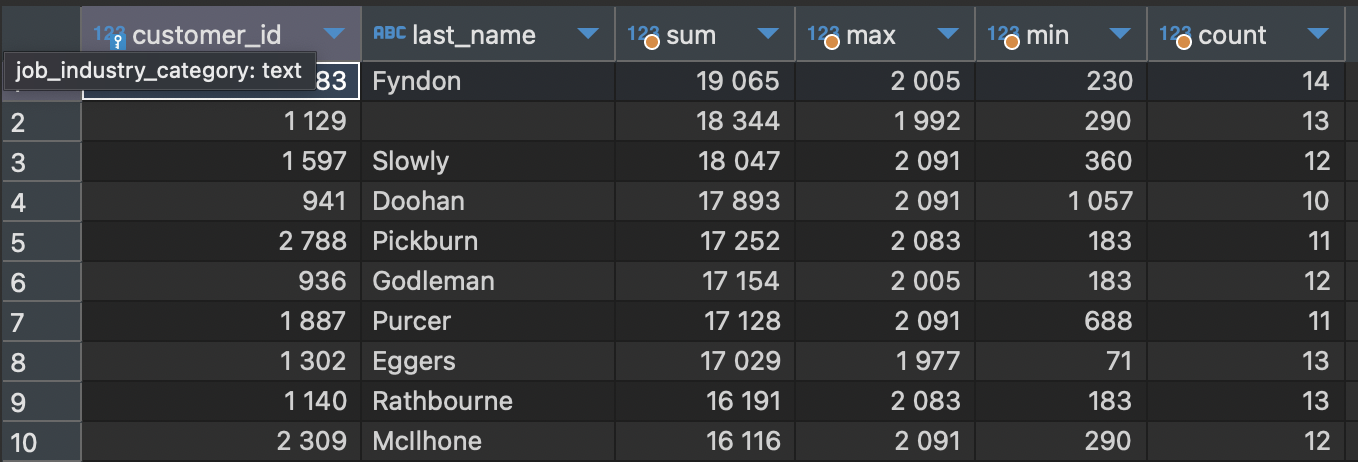

In [ ]:
select c.customer_id 
     ,sum(t2.list_price) over(partition by c.customer_id) as sum
     ,max(t2.list_price) over(partition by c.customer_id) as max
     ,min(t2.list_price) over(partition by c.customer_id) as min
     ,count(t2.list_price) over(partition by c.customer_id) as count
from customer c
join transaction2 t2 on c.customer_id = t2.customer_id
ORDER BY sum DESC, count DESC;

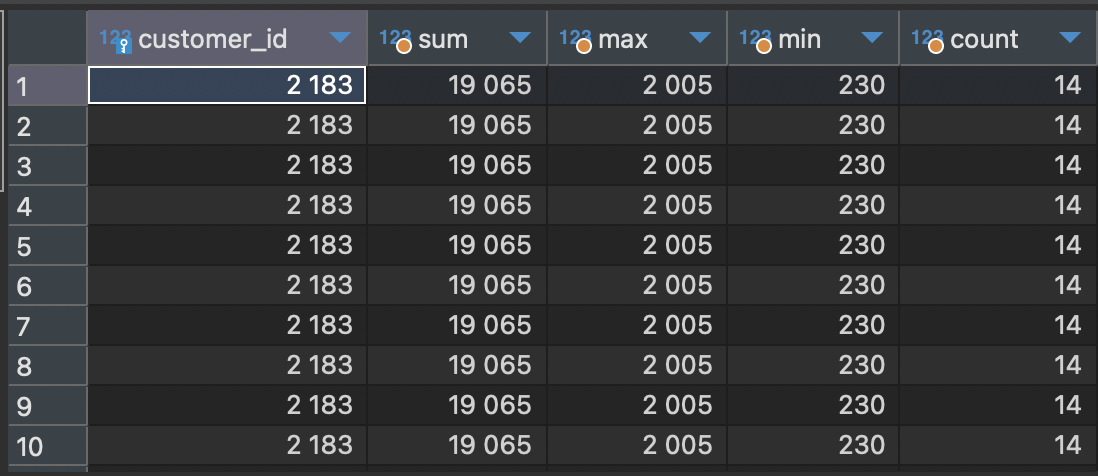

In [ ]:
При использовании оператора GROUP BY, данные группируются по заданному столбцу или столбцам, и агрегатные функции вычисляются для каждой группы. 
Это приводит к тому, что каждая строка в результирующем наборе будет представлять одну группу.

С использованием оконных функций, данные могут быть агрегированы без фактической группировки строк, что позволяет выполнять агрегатные функции без изменения количества строк в результате. 
Оконные функции работают на уровне строки, накладывая агрегатные функции на группы строк без фактической группировки.

5. Найти имена и фамилии клиентов с минимальной/максимальной суммой транзакций за весь период 
(сумма транзакций не может быть null). Напишите отдельные запросы для минимальной и максимальной суммы.

In [ ]:
select c.first_name,
       c.last_name,
       max(t2.list_price) as max_transaction
from customer c
join transaction2 t2 on c.customer_id = t2.customer_id
where t2.list_price is not null
group by c.first_name, c.last_name
order by max_transaction desc
limit 1

In [ ]:
select c.first_name,
       c.last_name,
       min(t2.list_price) as min_transaction
from customer c
join transaction2 t2 on c.customer_id = t2.customer_id
where t2.list_price is not null
group by c.first_name, c.last_name
order by min_transaction asc
limit 1

6. Вывести только самые первые транзакции клиентов. Решить с помощью оконных функций

In [ ]:
select distinct c.customer_id
      ,first_name
      ,last_name
      ,first_value(transaction_date) over(partition by c.customer_id order by transaction_date) as first_values
from customer c
join transaction2 t2 on c.customer_id = t2.customer_id

7. Вывести имена, фамилии и профессии клиентов, между транзакциями которых был максимальный интервал (интервал вычисляется в днях)

In [ ]:
with normalized_dates as (
    select 
        t.customer_id,
        c.first_name,
        c.last_name,
        c.job_title,
        to_date(t.transaction_date, 'dd.mm.yyyy') as normalized_date
    from transaction2 t
    join customer c on t.customer_id = c.customer_id
),
intervals as (
    select 
        customer_id,
        first_name,
        last_name,
        job_title,
        lag(normalized_date) over (partition by customer_id order by normalized_date) as lag_date,
        lead(normalized_date) over (partition by customer_id order by normalized_date) as lead_date
    from normalized_dates
)
select 
    first_name,
    last_name,
    job_title,
    lead_date - lag_date as max_date_difference
from intervals
where lag_date is not null and lead_date is not null
order by max_date_difference desc
limit 1;